In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams

import networkx as nx
import scipy.io

import numpy as np
import scipy as sc

# Graph Signal Processing Intro

Given an undirected, connected (and weighted) Graph $\mathcal G=\{\mathcal V, \textbf W or \textbf A\}$, where

$\mathcal V$ denotes a finite set of vertices with $|\mathcal V| = N$, 

and a (weighted) adjacency matrix $\textbf A$ ($\textbf W$) containing connections between vertices.

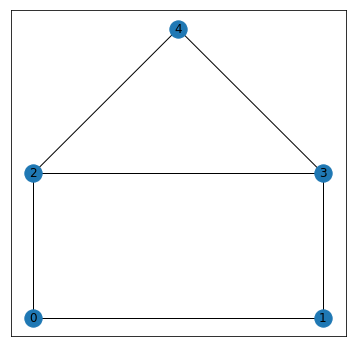

In [2]:
# toy example
G = nx.house_graph()
pos = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
    [0.5, 2.0]])

rcParams['figure.figsize'] = 6, 6
nx.draw_networkx(G, pos)

## Adjacency matrix $A$
If $a_i$ and $a_j$ are connected: 

$A_{ij}=1$ or $A_{ij}=w_{ij}$

otherwise

$A_{ij}=0$

In [3]:
A = nx.adjacency_matrix(G).todense()
A

matrix([[0, 1, 1, 0, 0],
        [1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0]], dtype=int64)

## Degree matrix $D$

$d_i=\sum_{j=0}^{n-1} A_{ij}$ - the number of edges incident to $d_i$ or if weighted, the sum of edge weights

$D = diag(d_0, d_1, ..., d_{n-1})$

In [4]:
d = np.sum(A, axis=0)
d

matrix([[2, 2, 3, 3, 2]], dtype=int64)

In [5]:
D = np.diagflat(d)
D

matrix([[2, 0, 0, 0, 0],
        [0, 2, 0, 0, 0],
        [0, 0, 3, 0, 0],
        [0, 0, 0, 3, 0],
        [0, 0, 0, 0, 2]], dtype=int64)

In [6]:
# laplacian
L = D - A
L

matrix([[ 2, -1, -1,  0,  0],
        [-1,  2,  0, -1,  0],
        [-1,  0,  3, -1, -1],
        [ 0, -1, -1,  3, -1],
        [ 0,  0, -1, -1,  2]], dtype=int64)

# Real-world example
Choose between Budapest and Minnesota

In [7]:
def plot_graph(G, pos, vals=None, cmap=None, node_size=8, fig_size=(20,20)):
    rcParams['figure.figsize'] = fig_size
    if vals is not None:
        nx.draw(G, pos, node_color=vals, cmap=cmap, vmin=vals.min(), vmax=vals.max(), node_size=node_size)
    else:
        nx.draw(G, pos, node_size=node_size)
        
    plt.show()

## Budapest public transport network
Source: BKK

Processed by: Vince Szabo

In [30]:
import json
import utm

with open('data/bkk.json', 'r') as f:
    bkk = json.load(f)

verts = bkk['VertexData']
edges = bkk['Edges']

# Processing data
id_lookup = [node['Id'] for node in verts]
names = [node['Name'] for node in verts]
pos = np.array(
    [utm.from_latlon(node['Latitude'], node['Longitude'])[:2] 
                 for node in verts])

edges = np.array([(id_lookup.index(e[0]), id_lookup.index(e[1])) 
                  for e in edges if e[0] in id_lookup and e[1] in id_lookup])


In [9]:
# Constructing graph
G = nx.Graph()
G.add_nodes_from(range(len(id_lookup)))
G.add_edges_from(edges)

In [10]:
A = nx.adjacency_matrix(G)
A

<5413x5413 sparse matrix of type '<class 'numpy.int64'>'
	with 13288 stored elements in Compressed Sparse Row format>

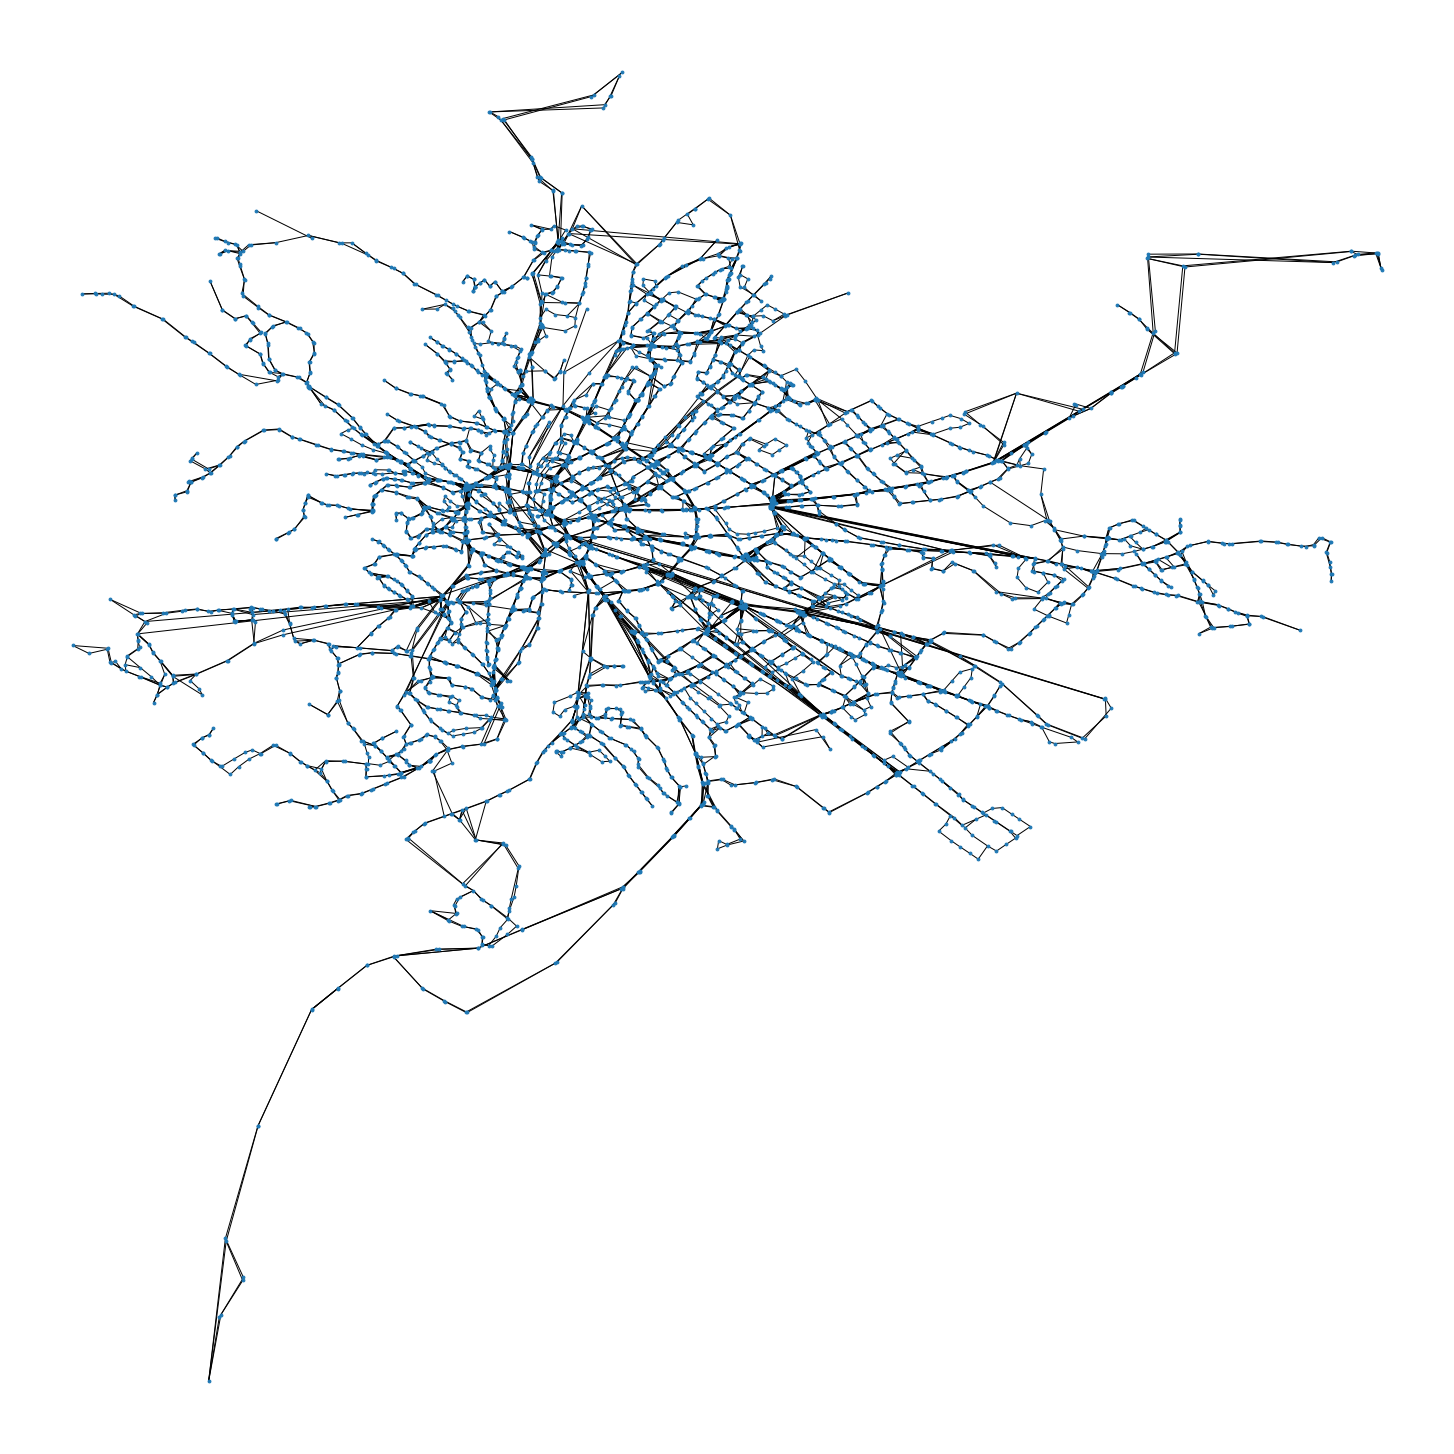

In [31]:
plot_graph(G, pos)

## Minnesota road network

In [23]:
mat = scipy.io.loadmat('data/minnesota.mat')

In [24]:
# Adjacency matrix
A = mat['A']
A

<2642x2642 sparse matrix of type '<class 'numpy.float64'>'
	with 6606 stored elements in Compressed Sparse Column format>

In [25]:
# Node attributes
pos = mat['xy']
pos

array([[-97.207,  49.001],
       [-96.801,  49.   ],
       [-95.957,  49.   ],
       ...,
       [-93.247,  43.5  ],
       [-93.353,  43.5  ],
       [-93.493,  43.499]])

In [26]:
G = nx.from_scipy_sparse_matrix(A)

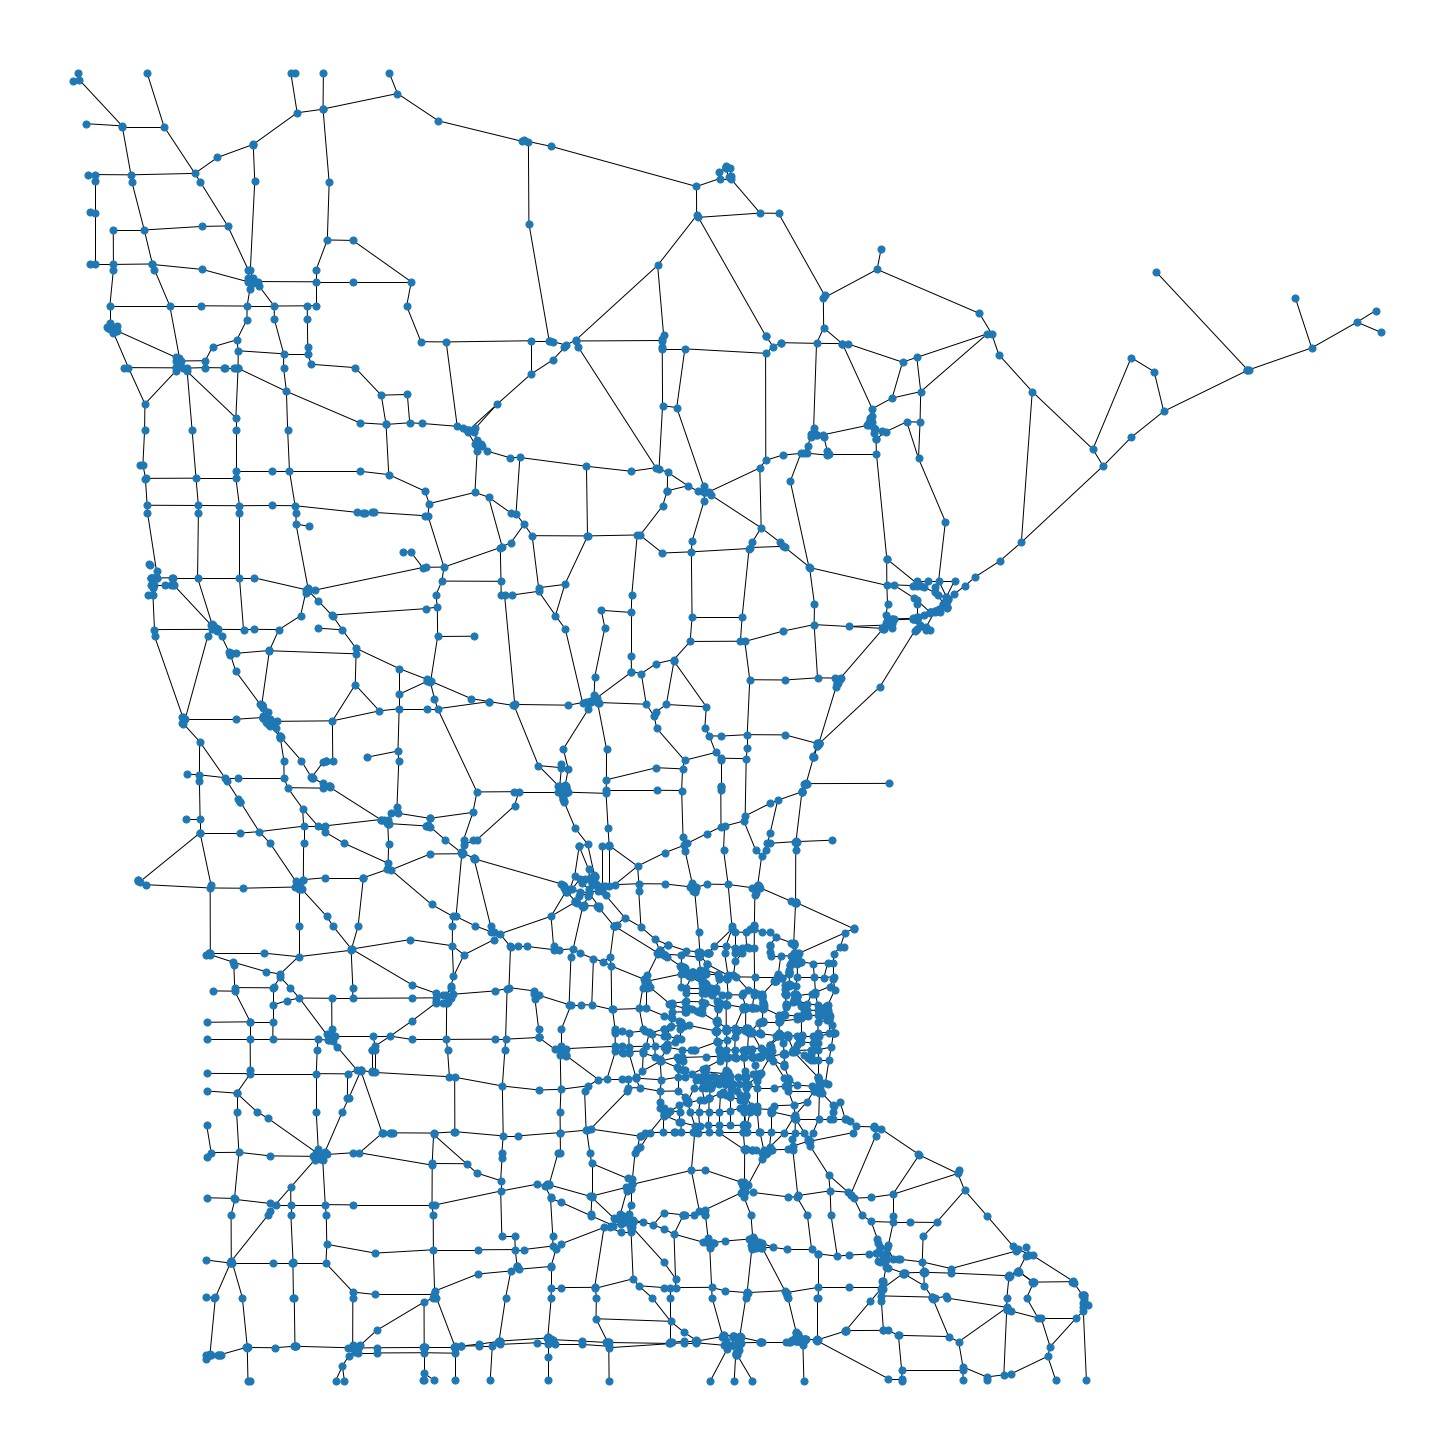

In [28]:
plot_graph(G, pos, node_size=50)

### Sparsity of the adjacency matrix $A$

In [12]:
def show_sparsity(mat):
    rcParams['figure.figsize'] = 20, 20

    fig = plt.figure()
    ax1 = fig.add_subplot(221)

    ax1.spy(mat, precision=0.1, markersize=1)
    plt.show()

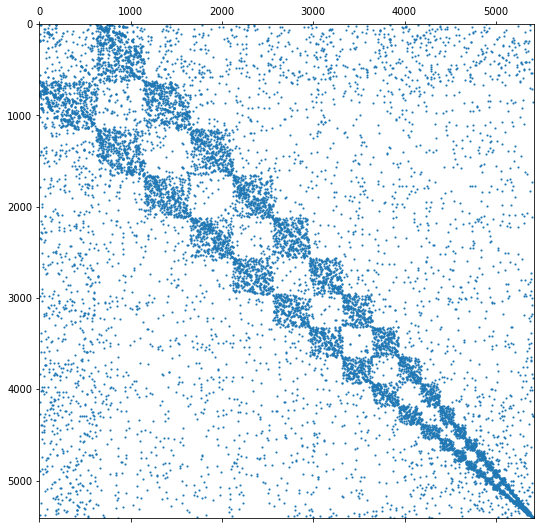

In [13]:
show_sparsity(A)

## Fourier transform

Fourier Basis...

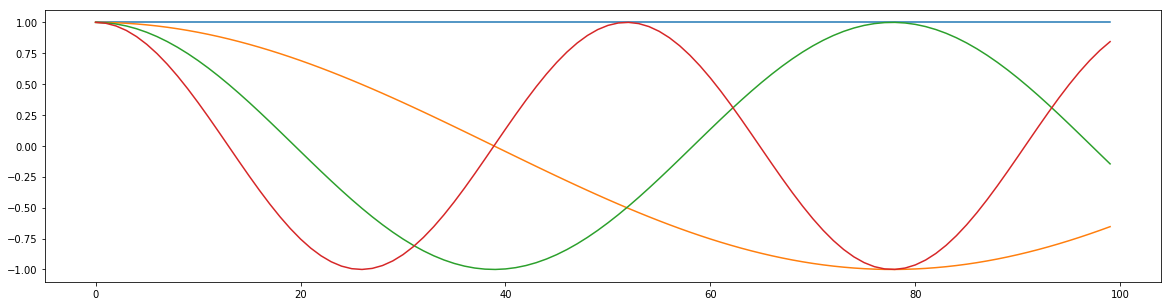

In [14]:
freqs = range(4)

bases = lambda x, k: np.cos(k * x)

rcParams['figure.figsize'] = 20, 5
for k in freqs:
    plt.plot(bases(np.linspace(0, 4, 100), k))

# todo add 

plt.show()
plt.close()


## Signals on a Graph


$ x:\mathcal V \rightarrow \mathbb R$

Which can be represented as a vector $x \in \mathbb R^n$ where $x_i$ is the value of the $x$ at the $i^{th}$ node.

## Graph laplacian

$L_{i, j} :=\left\{\begin{array}{ll}{\operatorname{deg}\left(v_{i}\right)} & {\text { if } i=j} \\ {-1} & {\text { if } i \neq j \text { and } v_{i} \text { is adjacent to } v_{j}} \\ {0} & {\text { otherwise }}\end{array}\right.$

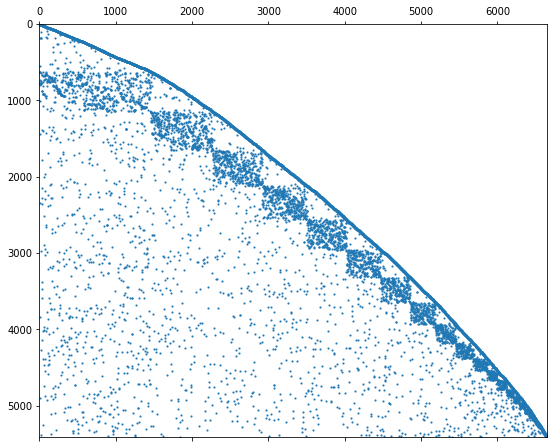

In [15]:
D = nx.incidence_matrix(G, oriented=True)
show_sparsity(D)
D = D*D.T

In [16]:
L = nx.linalg.laplacian_matrix(G, weight=None).astype(np.float)

In [17]:
L2 = (D - A).astype(np.float)

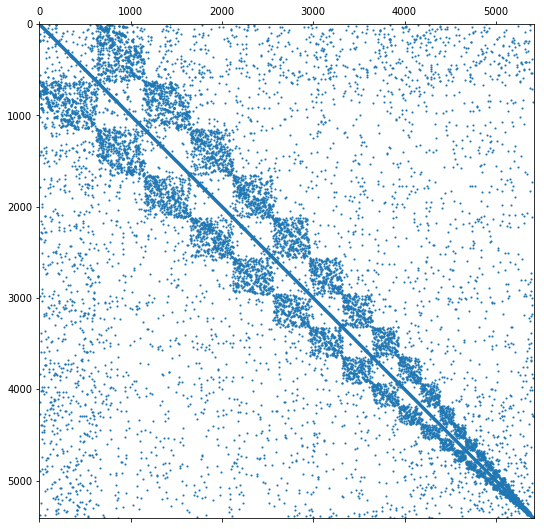

In [18]:
show_sparsity(L)

In [35]:
# parallel with R

# Fourier Transform

## Eigenvalue decomposition

$L$ is symmetric -> n orthonormal bases.

$L$ is semi-positive definite -> non-negative eigenvalues

In [20]:
!pip install block_timer
from block_timer.timer import Timer

In [22]:
# Sparse (Hermatian) computation, first K
with Timer('Sparse Hermatian'):
    l, U = sc.sparse.linalg.eigsh(L, k=10, which='SM')
l

[Sparse Hermatian] Total time 4.64792 seconds.


array([-2.24458057e-16,  4.02750691e-17,  3.12916676e-16,  5.71285245e-16,
        6.00210367e-16,  9.98641886e-16,  1.46423619e-03,  1.66595904e-03,
        2.38395000e-03,  2.88839979e-03])

In [21]:
# Sparse computation, not all possible
with Timer('Sparse'):
    l, U = sc.sparse.linalg.eigs(L, k=10, which='SM')
l

[Sparse] Total time 22.64838 seconds.


array([ 1.11835233e-15+0.00000000e+00j,  1.28424088e-15+0.00000000e+00j,
       -4.76442043e-16+0.00000000e+00j, -5.88939690e-17+0.00000000e+00j,
       -9.78338290e-18+0.00000000e+00j,  7.01621325e-16+0.00000000e+00j,
       -4.98346492e-17+3.66800931e-17j, -4.98346492e-17-3.66800931e-17j,
       -3.01916088e-17+0.00000000e+00j,  1.04861806e-16+0.00000000e+00j])

In [ ]:
# Sparse (Hermatian) computation, not all possible
with Timer('Sparse Hermatian'):
    l, U = sc.sparse.linalg.eigsh(L, k=L.shape[0]-1)
l

In [15]:
# Dense computation
with Timer('Dense'):
    l, U = sc.linalg.eig(L)
l

[Dense] Total time 0.02126 seconds.


array([-8.88178420e-16+0.j,  4.61803399e+00+0.j,  1.38196601e+00+0.j,
        2.38196601e+00+0.j,  3.61803399e+00+0.j])

In [ ]:
# Dense (Hermatian) computation
with Timer('Dense Hermatian'):
    lambda_full, U_full = sc.linalg.eigh(L.toarray())
lambda_full

## $U$ is not sparse

In [ ]:
#plt.matshow(U_full)
show_sparsity(U_full)

### Eigen values

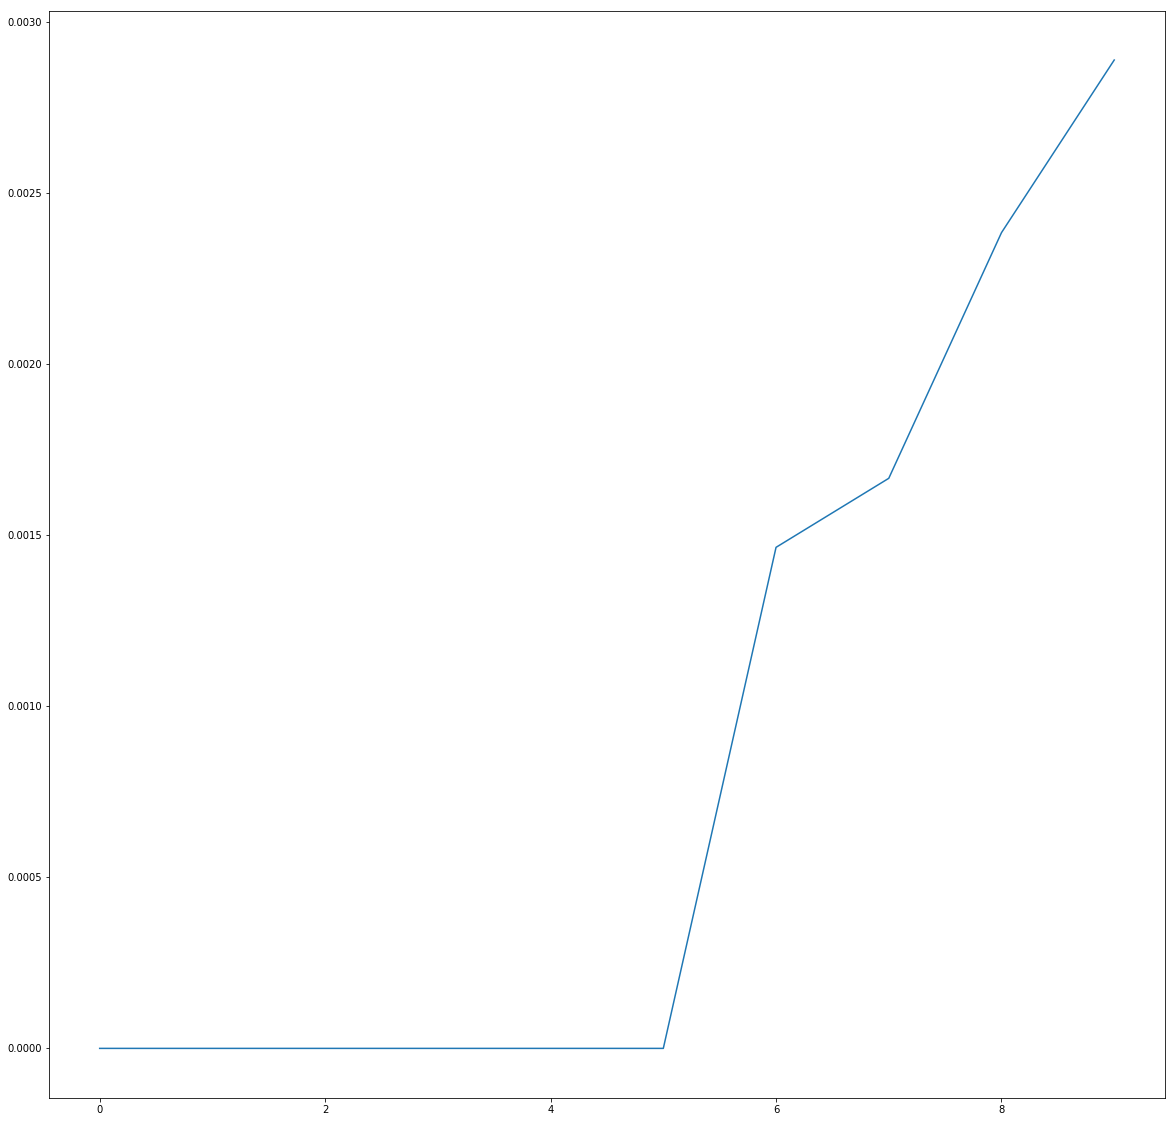

In [24]:
plt.plot(l)
plt.show()

In [25]:
import seaborn as sns
# heatmap = plt.cm.get_cmap('hot')
heatmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

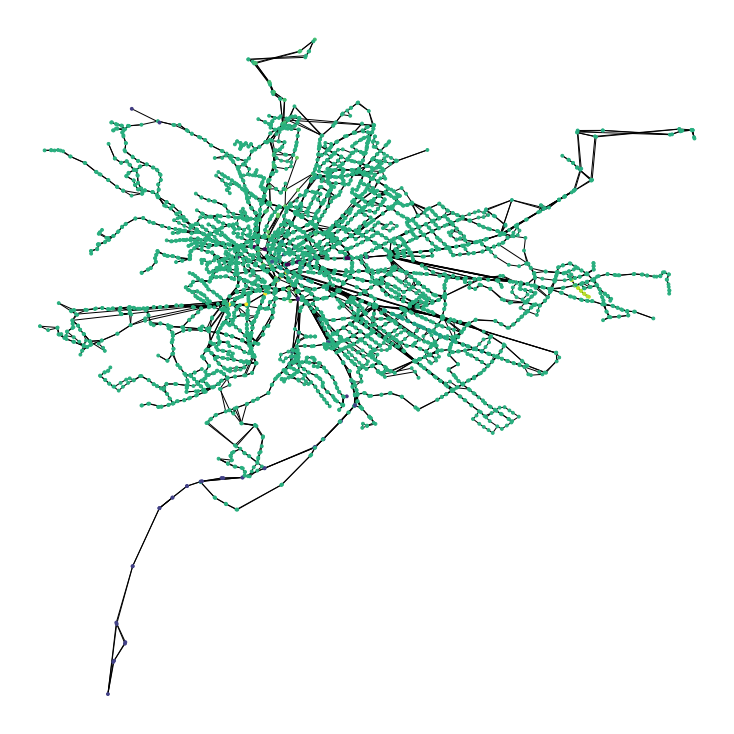

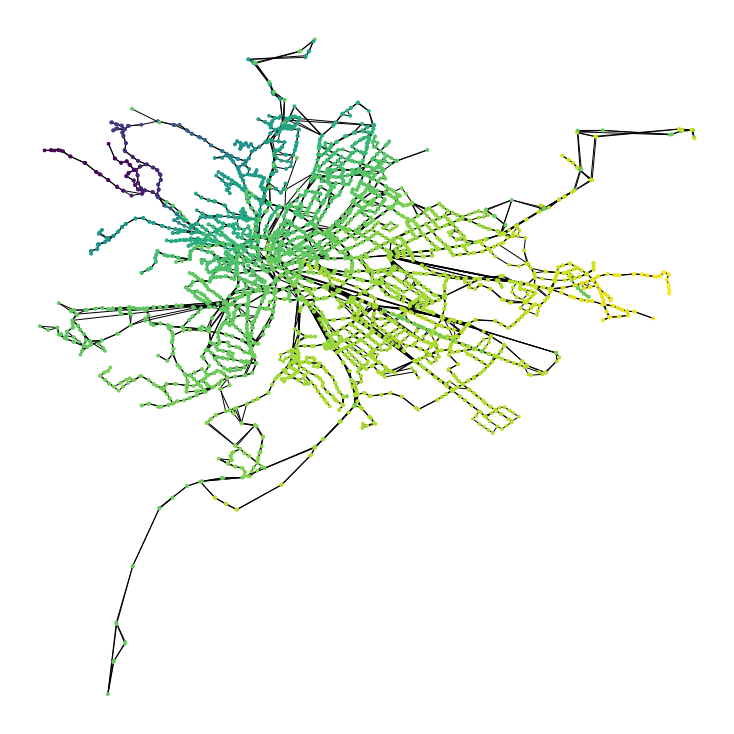

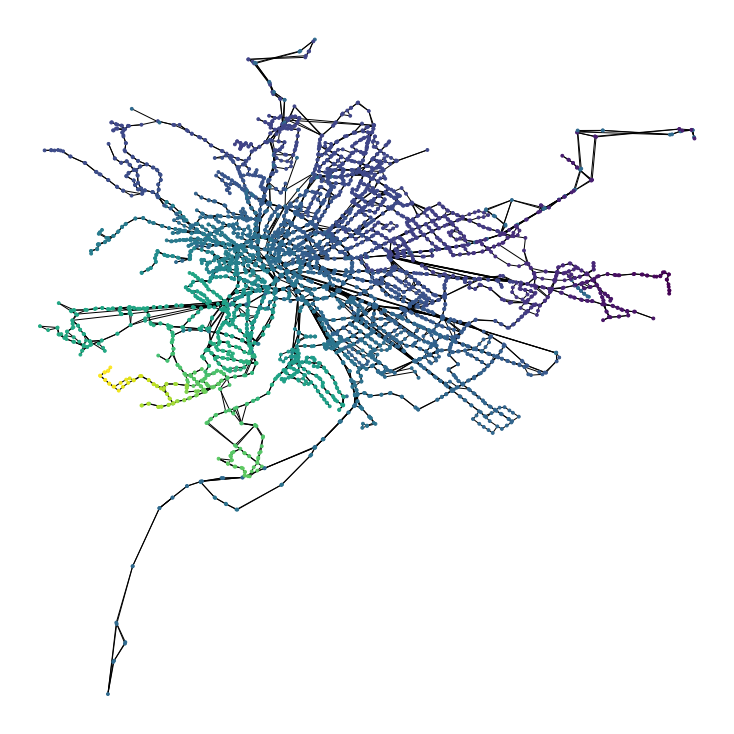

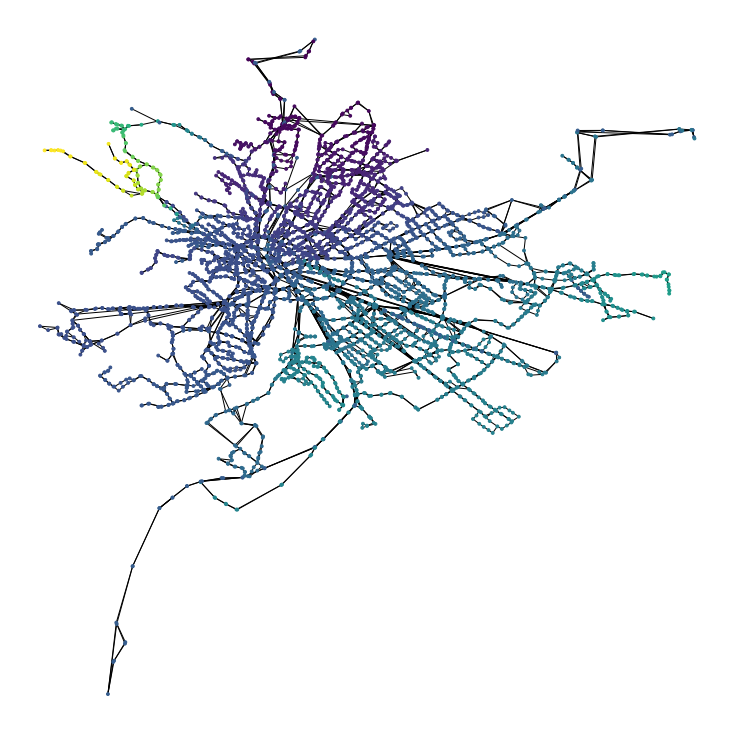

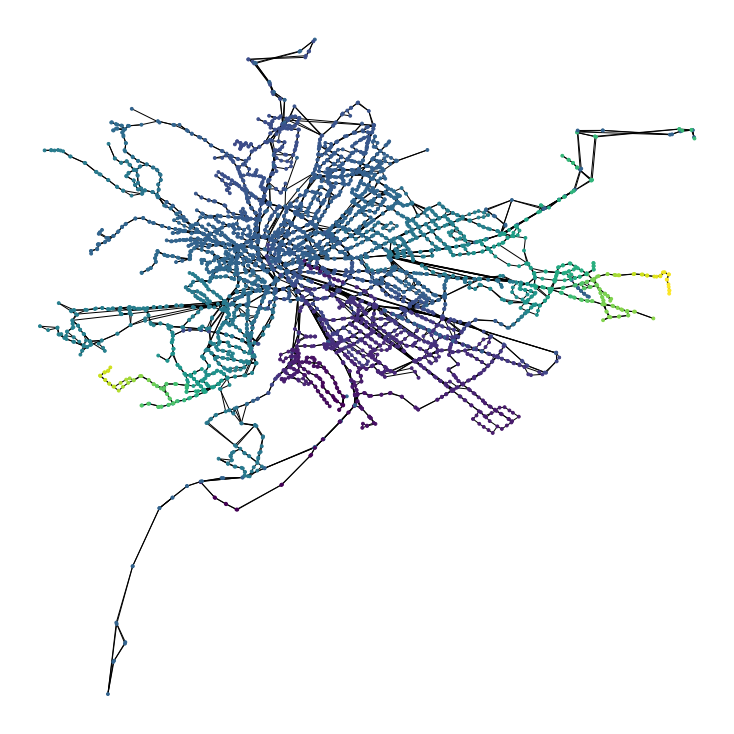

In [28]:
# plot fourier basis
for i in range(5, 10):
    plot_graph(G, pos, U[:, i], None, fig_size=(10, 10))
    plt.show()
    plt.close()

## Fourier transform
The Laplacian is diagonalized by the Fourier basis $U \in \mathbb{R}^{n\times n}$

$L=U\Lambda U^T$

$U = [u_0, u_1, ..., u_{n-1}]$ - Orthonormal eigenvectors of $L$

$\Lambda = diag([\lambda_0, \lambda_1, ..., \lambda_{n-1}]) \in \mathbb{R}^{n\times n}$ - Real, non-negative eigenvalues

### Fourier transform from mesh vertices to spectral domain:

#### $x_\omega = U^T x$

Where $x \in \mathbb{R}^{n \times 3}$ is a signal on the graph

## Filtering

$y=g_\theta (L)x$

$g_\theta (L)$ parametric filter with learnable weights $\theta$


### Spectral filter

$y=g_\theta (L)x = g_\theta(U\Lambda U^T)x = U g_\theta(\Lambda)U^T x $
                                    
Filter in spectral domain, transform back to spatial domain                                    
                                    
- $g_\theta (L)$ - spectral filter
- $\theta$ are learnable parameters, in the form of $\theta \in \mathbb R^n$ Fourier coefficients
- $L$ is a domain specific parameter

In [ ]:
def spectral_filter(theta, L):
    pass 

x = pos
g_theta = spectral_filter(theta, L)
y = U @ g_theta @ U.T @ x

### Disadvantages of non-parametric filters
- not localized in space
- learning complexity $\mathcal O(n)$

#### Polynomial filter
$$g_\theta(\Lambda)=\sum_{k=1}^{K-1} \theta_k \Lambda ^k$$

- $\theta \in \mathbb R^K$ polynomial coefficients

In [ ]:
def poly_filter(theta, K, L):
    """
    theta: learnable params, polynomial coefficients
    K: support of filter, acts on K-neighborhood of nodes
    L: filter parameter (diagonal eigen value matrix)
    """
    y = 0
    l_k = np.identity(L.shape[0])
    for k in range(K):
        print(l_k)
        y += theta[k] * l_k
        l_k = np.matmul(l_k, L)
    return y

K = 2
theta = np.random.rand(K)

Lambda = np.diagflat(l[:K])
g_t = poly_filter(theta, K, Lambda)

x = pos[:,0]
x_omega = U.T @ x  # [n, n] x [n, 1]
filter_x = g_t @ x_omega
y = U @ filter_x

In [34]:
L

<5413x5413 sparse matrix of type '<class 'numpy.float64'>'
	with 18701 stored elements in Compressed Sparse Row format>

### Localized filter
$(g_\theta (L)\delta_i)_j = (g_\theta (L))_{i,j} = \sum_k \theta_k (L^k)_{i,j} $
- the value at vertex $j$ of the filter $g_\theta$
- centered at vertex $i$
- $\delta _i \in \mathbb R^n$ the kernel is localized by the Kronecker delta function (via convolution)


"Spectral filters represented by $K^{th}$-order polynomials of the Laplacian are exactly $K$-localized"

$\mathcal O (K)$ - the support size, the asme as classical CNNs

# Fast spectral convolutions

Despite learning complexity being lower, the cost of filtering is still high ($\mathcal O(n^2)$)

$y=Ug_\theta (\Lambda)U^Tx$

This is caused by the multiplication with the Fourier basis $U$. (dense)

## Chebyshev polynomials

$$g_\theta(L) = \sum_{k=0}^{K-1}\theta_k T_k(\tilde L)$$

where
- $\tilde L=2L/\lambda_{max} - I_n$  Scaled laplacian

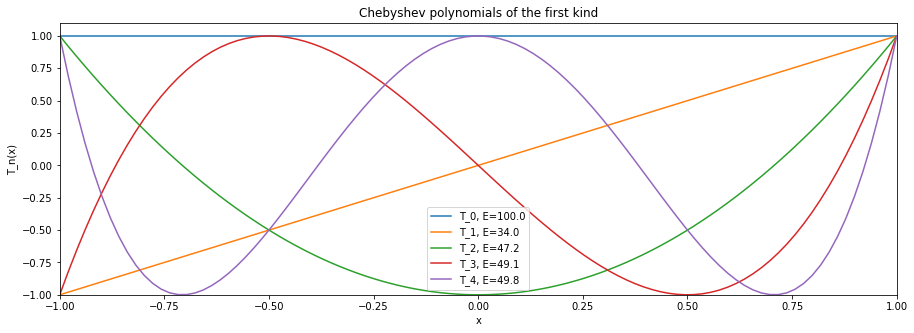

In [35]:
# source: Fast spectral conv
K = 5

def cheby_basis(K, x):
    """Return the Chebyshev basis of order K (composed of the
    first K polynomials) evaluated at x. Polynomials are generated
    by their recursive formulation."""
    T = np.empty((x.size, K))
    T[:,0] = np.ones(x.size)
    if K >= 2:
        T[:,1] = x
    for k in range(2, K):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
#    T /= np.linalg.norm(T, axis=0)  # Scaling to unit norm.
    return T

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
x = np.linspace(-1,1,100)
T = cheby_basis(K, x)
for k in range(K):
    ax.plot(x, T[:,k], label='T_{}, E={:.1f}'.format(k, np.linalg.norm(T[:,k])**2))
ax.set_title('Chebyshev polynomials of the first kind')
ax.set_xlabel('x')
ax.set_ylabel('T_n(x)')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1.1)
ax.legend(loc='best')
plt.show()

In [36]:
def rescale_L(L, lmax=2):
    """Rescale the Laplacian eigenvalues in [-1,1]."""
    M, M = L.shape
    I = scipy.sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax / 2
    L -= I
    return L


def chebyshev(L, X, K):
    """Return T_k X where T_k are the Chebyshev polynomials of order up to K.
    Complexity is O(KMN)."""
    M, N = X.shape
    assert L.dtype == X.dtype

    # L = rescale_L(L, lmax)
    # Xt = T @ X: MxM @ MxN.
    Xt = np.empty((K, M, N), L.dtype)
    # Xt_0 = T_0 X = I X = X.
    Xt[0, ...] = X
    # Xt_1 = T_1 X = L X.
    if K > 1:
        Xt[1, ...] = L.dot(X)
    # Xt_k = 2 L Xt_k-1 - Xt_k-2.
    for k in range(2, K):
        Xt[k, ...] = 2 * L.dot(Xt[k-1, ...]) - Xt[k-2, ...]
    return Xt

## Filtering
$y_{s,j} = \sum_{i-1}^{F_{in}}g_{\theta_{i,j}}(L) x_{s,i} \in \mathbb R^n$

- $s$ sample
- $i$ ith input feature
- $j$ jth output feature 
- $y_{s, j}$ is the $j^{th}$ output feature map (1 value for every vertex)
- $x_{s,i}$ input feature maps
- $ \theta_{i,j} \in \mathbb R^K$ * F_in x F_out

No multiplication with $U$, $L$ is sparse

In [37]:
L_norm = nx.normalized_laplacian_matrix(G)#.todense()
L_norm

<5413x5413 sparse matrix of type '<class 'numpy.float64'>'
	with 18701 stored elements in Compressed Sparse Row format>

$T() x...$

In [39]:
T = chebyshev(L_norm, pos, 5)  # [K, N, Features]
T

array([[[ 3.57122138e+05,  5.25111917e+06],
        [ 3.52120893e+05,  5.25449020e+06],
        [ 3.48972882e+05,  5.26641815e+06],
        ...,
        [ 3.58398934e+05,  5.27165709e+06],
        [ 3.58432406e+05,  5.27194507e+06],
        [ 3.58509142e+05,  5.27220712e+06]],

       [[-1.63832753e+02, -3.58900202e+01],
        [ 1.03197358e+05,  1.53880408e+06],
        [-3.14326701e+02,  2.85765900e+02],
        ...,
        [-7.08139154e+00, -1.82369930e+01],
        [-2.16321719e+01,  1.29622347e+01],
        [ 3.28620351e+04,  4.83624301e+05]],

       [[-3.57777469e+05, -5.25126273e+06],
        [-4.25549314e+04, -6.37850235e+05],
        [-4.74577724e+05, -7.14978816e+06],
        ...,
        [-3.58412785e+05, -5.27172466e+06],
        [-3.91330624e+05, -5.75552521e+06],
        [-2.70899346e+05, -3.98267497e+06]],

       [[-2.12982578e+03, -4.66570262e+02],
        [ 7.67956712e+05,  1.14544594e+07],
        [-6.59687876e+05, -9.92578307e+06],
        ...,
        [ 9.873849

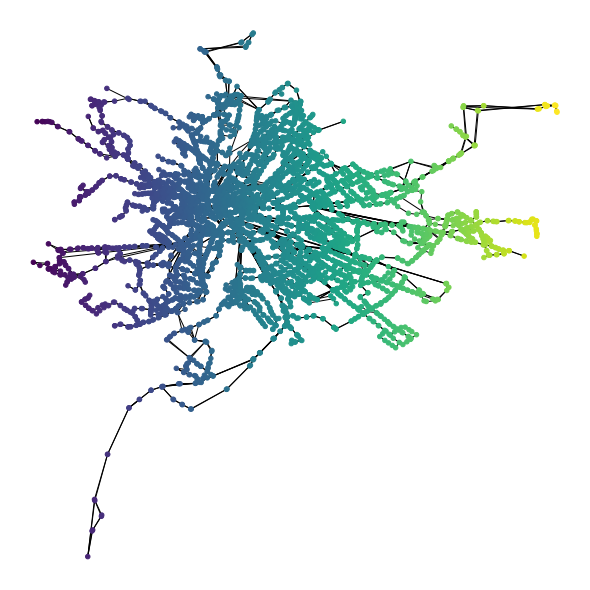

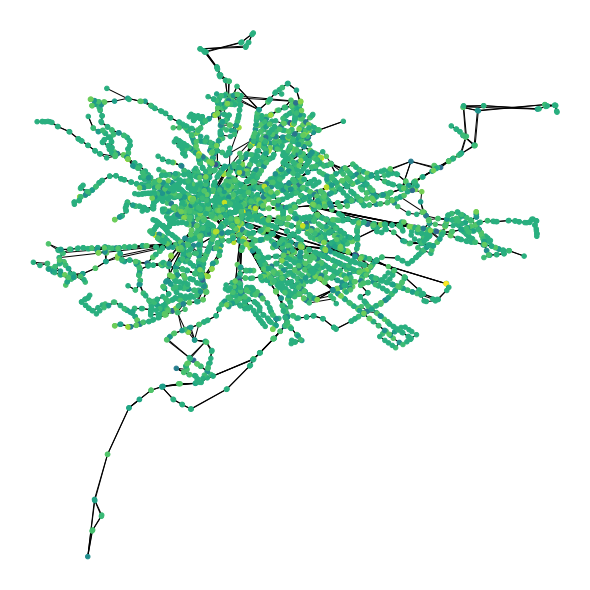

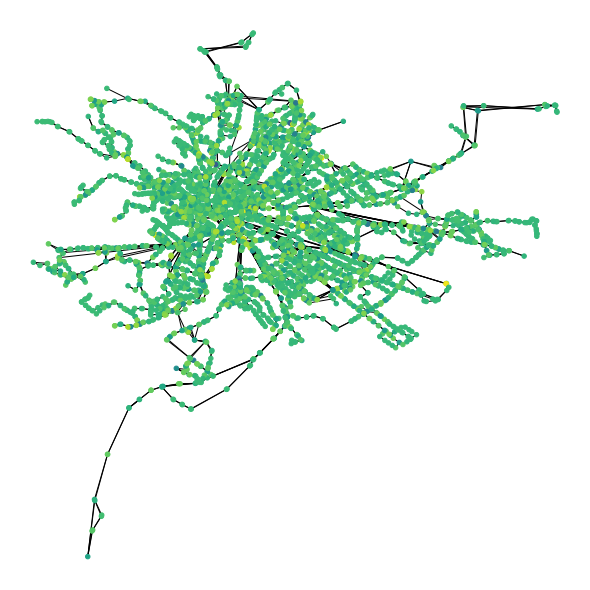

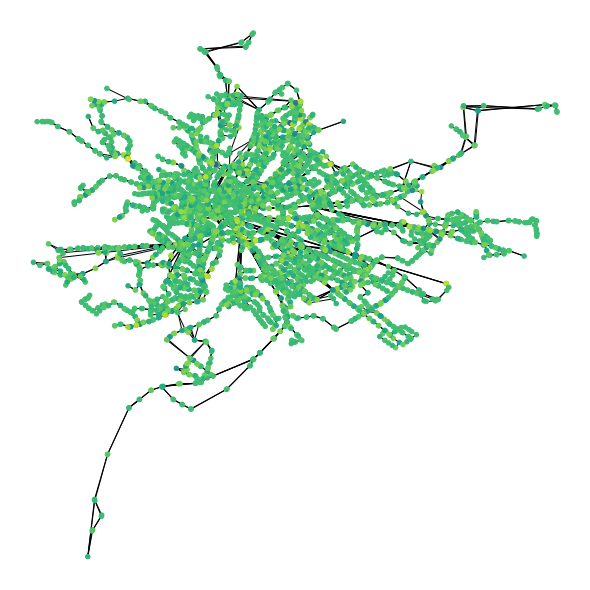

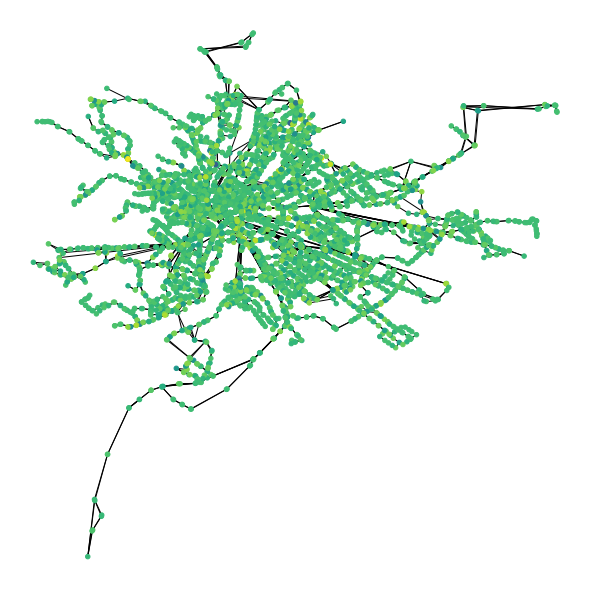

In [43]:
# plot signal 0 in Chebyshev basis?
for i in range(5):
    plot_graph(G, pos, T[i, :, 0], None, node_size=20, fig_size=(8,8))
    plt.show()
    plt.close()